In [30]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_excel('../data/Exercise #2.xlsx')

# Clean and trim column names
data.columns = (data.columns
                         .str.strip()                               # Remove leading and trailing spaces
                         .str.replace(r'\s+', '_', regex=True)      # Replace multiple spaces with a single underscore
                         .str.lower()                               # Convert to lowercase
                         .str.replace(r'[^\w]', '_', regex=True)    # Replace non-alphanumeric characters with underscores
                         .str.replace(r'_{2,}', '_', regex=True)    # Replace multiple consecutive underscores with a single underscore
                         .str.strip('_')                            # Remove leading and trailing underscores
                        )

print(data.columns)

# Display the first few rows of the dataset
data.head()


Index(['mirc_subpractice', 'attorney_on_case', 'client_birthdate',
       'client_country_of_origin', 'client_language', 'client_city',
       'immigration_court_location', 'event_type', 'event_date',
       'application_petition_type',
       'application_petition_outcome_date_if_applicable',
       'application_petition_outcome', 'court_hearing_is_remote_or_in_person',
       'reason_for_application_petition_denial_provided_by_uscis',
       'reason_for_case_representation_ended_if_applicable'],
      dtype='object')


,mirc_subpractice,attorney_on_case,client_birthdate,client_country_of_origin,client_language,client_city,immigration_court_location,event_type,event_date,application_petition_type,application_petition_outcome_date_if_applicable,application_petition_outcome,court_hearing_is_remote_or_in_person,reason_for_application_petition_denial_provided_by_uscis,reason_for_case_representation_ended_if_applicable
0,Released,BB,2008-02-10,Afghanistan,NaN,Grand Rapids,Detroit,Application/petition filed,2022-09-13 00:00:00,I-485,2022-09-21,Denied,NaN,Fee not included,NaN
1,Released,BB,NaT,Afghanistan,NaN,Kalamazoo,Detroit,Application/petition filed,2022-11-12 00:00:00,I-360,2022-11-23,Denied,NaN,Request for evidence not responded to,NaN
2,Released,DD,2008-03-29,Afghanistan,Pashto,Ypsilanti,Detroit,Application/petition filed,2022-12-16 00:00:00,State Court Petition,NaT,Pending,NaN,NaN,Immigration Relief Granted
3,Released,CC,2005-06-12,Afghanistan,NaN,Traverse City,Detroit,Application/petition filed,2022-09-22 00:00:00,State Court Petition,2022-10-01,Granted,NaN,NaN,NaN
4,Released,CC,2004-03-15,Afghanistan,NaN,Traverse City,Detroit,Application/petition filed,2022-12-22 00:00:00,State Court Petition,NaT,Pending,NaN,NaN,NaN


In [31]:
# Convert date columns to datetime
data['event_date'] = pd.to_datetime(data['event_date'])
data['application_petition_outcome_date_if_applicable'] = pd.to_datetime(data['application_petition_outcome_date_if_applicable'])

# Calculate Processing Time
data['processing_time'] = data['application_petition_outcome_date_if_applicable'].fillna(pd.Timestamp.now()) - data['event_date']
data['processing_time'] = data['processing_time'].dt.days

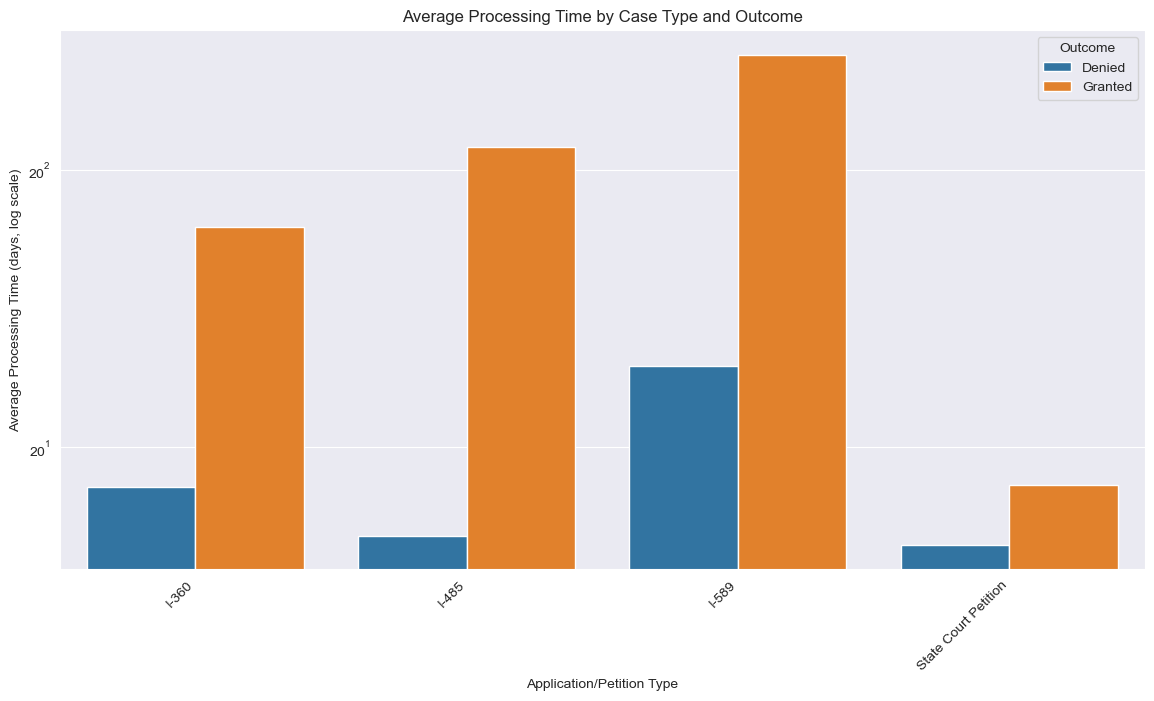

In [32]:
# Group by application_petition_type and application_petition_outcome, then calculate mean processing time
approval_timeline = data.groupby(['application_petition_type', 'application_petition_outcome'])['processing_time'].mean().reset_index()

# Filter out 'Pending' and 'Withdrawn' outcomes
approval_timeline_filtered = approval_timeline[~approval_timeline['application_petition_outcome'].isin(['Pending', 'Withdrawn'])]

# Plotting the results
plt.figure(figsize=(14, 7))
sns.barplot(x='application_petition_type', y='processing_time', hue='application_petition_outcome', data=approval_timeline_filtered, palette='tab10')

# Apply logarithmic scale to y-axis
plt.yscale('log', base=20)

plt.xticks(rotation=45, ha='right')
plt.title('Average Processing Time by Case Type and Outcome')
plt.xlabel('Application/Petition Type')
plt.ylabel('Average Processing Time (days, log scale)')
plt.legend(title='Outcome')
plt.show()


In [37]:
count_df = data.groupby(['application_petition_type', 'application_petition_outcome']).size().reset_index(name='count')

# Pivot the data to get counts of Granted and Denied per type
pivot_df = count_df.pivot_table(index='application_petition_type', 
                                columns='application_petition_outcome', 
                                values='count', 
                                fill_value=0)

# Calculate the ratio of Denied to Granted
pivot_df['Ratio_Denied_to_Granted'] = pivot_df['Denied'] / pivot_df['Granted'].replace(0, pd.NA)  # Handle division by zero

# Reset index for easier readability
pivot_df = pivot_df.reset_index()

pivot_df


application_petition_outcome,application_petition_type,Denied,Granted,Pending,Withdrawn,Ratio_Denied_to_Granted
0,I-360,2.0,6.0,1.0,0.0,0.333333
1,I-485,3.0,4.0,2.0,0.0,0.750000
2,I-589,12.0,4.0,9.0,3.0,3.000000
3,State Court Petition,2.0,11.0,6.0,0.0,0.181818
